# Notebook demonstrating fitting of $hrz0$ to site data
The below code shows how to use data from fixed-tilt experiments to compute the free parameter $hrz0$. The dust distribution is currently assumed and its parameters are defined in the file `parameters_qut_experiments.xlsx`.

In [1]:
import numpy as np
import soiling_model.base_models as smb
import soiling_model.fitting as smf
import soiling_model.utilities as smu
from matplotlib import rcParams
import pickle
from scipy.stats import norm
rcParams['figure.figsize'] = (10, 7)
# %matplotlib qt

ls_save_file = "./results/ls_fitting_results_qut"
sp_save_file = "./results/sp_fitting_results_qut"
cm_save_file = "./results/cm_fitting_results_qut"
reflectometer_incidence_angle = 15 # angle of incidence of reflectometer
reflectometer_acceptance_angle = 12.5e-3 # half acceptance angle of reflectance measurements
k_factor = 2.404 # calibration factor for TSP measurements in experiments
second_surf = True # True if using the second-surface model. Otherwise, use first-surface
d = "data/public/qut_experiments/" # directory of parameter files (be sure to follow naming convention)
test_time_at_end = [0,0,0,0] # amount of test time to leave at the end of each file
parameter_file = d+"parameters_qut_experiments.xlsx"

## Load in data and divide into training and testing

Specify mirrors for training, the k-factors of the dust measurements (if any), and the type of dust measurement (PMX or TSP).

In [2]:
train_experiments = [0,1] # indices for training experiments from 0 to len(files)-1
train_mirrors = ["Mirror_1"] # which mirrors within the experiments are used for training
files_experiment,training_intervals,mirror_name_list,all_mirrors = smu.get_training_data(d,"experiment_")
dust_type = "TSP"

extract = lambda x,ind: [x[ii] for ii in ind]
files_experiment_train = extract(files_experiment,train_experiments)
training_intervals = extract(training_intervals,train_experiments)
t = [t for t in train_experiments]
training_string = "Training: "+str(train_mirrors)+", Exp: "+str(t)

Instantiate model and load in training data

In [3]:
imodel = smf.semi_physical(parameter_file)
sim_data_train = smb.simulation_inputs( files_experiment_train,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )
reflect_data_train = smb.reflectance_measurements(  files_experiment_train,
                                                    sim_data_train.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=train_mirrors
                                                    )


Importing constants
Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
No wind direction data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
No wind direction data to import.
Importing dust properties for each experiment
Loading source (normalized) intensity from data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx
Loading source (normalized) intensity from data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx


Trim training data to specified ranges. The second trim ensures that the weather variables stop at the limits of the reflectance data

In [4]:
            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                training_intervals 
                                                            )
                                                            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                "reflectance_data" 
                                                            )


Load in the total data

In [5]:

sim_data_total = smb.simulation_inputs( files_experiment,
                                        k_factors=k_factor,
                                        dust_type=dust_type
                                        )

reflect_data_total = smb.reflectance_measurements(  files_experiment,
                                                    sim_data_total.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=reflectometer_incidence_angle,
                                                    reflectometer_acceptance_angle=reflectometer_acceptance_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=None
                                                    )


Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
No wind direction data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
No wind direction data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 200 hours
Length of simulation for file data/public/qut_experiments/experiment_20170905_20170913_cinque.xlsx: 8.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
No wind direction data to import.
Importing s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


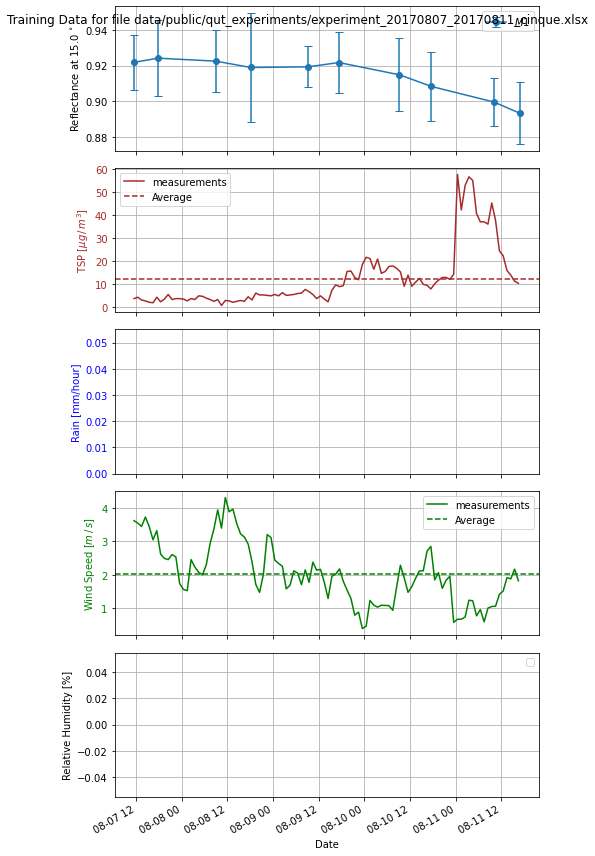

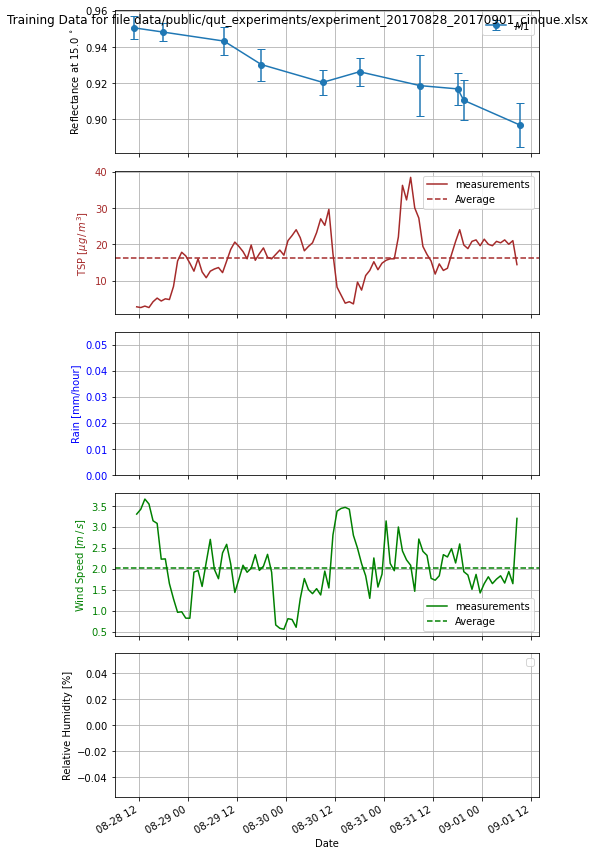

In [6]:
for ii,experiment in enumerate(files_experiment_train):
    fig,ax = smu.plot_experiment_data(sim_data_train,reflect_data_train,ii)
    fig.suptitle(f"Training Data for file {experiment}")

### Compute extinction weights for both simulation datasets and plot. 
Note that the extinction weights depend only on the refractive index. If the refractive index is the same for all experiments, all extinction weights will be the same (and the computation will be faster.)

In [7]:
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
imodel.helios.compute_extinction_weights(sim_data_train,imodel.loss_model,verbose=True)

Setting tilts for 2 experiments
Second surface model
Second surface model
Loss Model is mie. Computing extinction coefficients ... 
	 Computing weights for file 0, heliostat 0...
	 Acceptance angle cosine = 0.999922
	 Using weights from file 0, mirror 0 for file 1, mirror 0...
... Done!


Plot extinction weights and save for later, since extinction weights are the same for all files in this example.

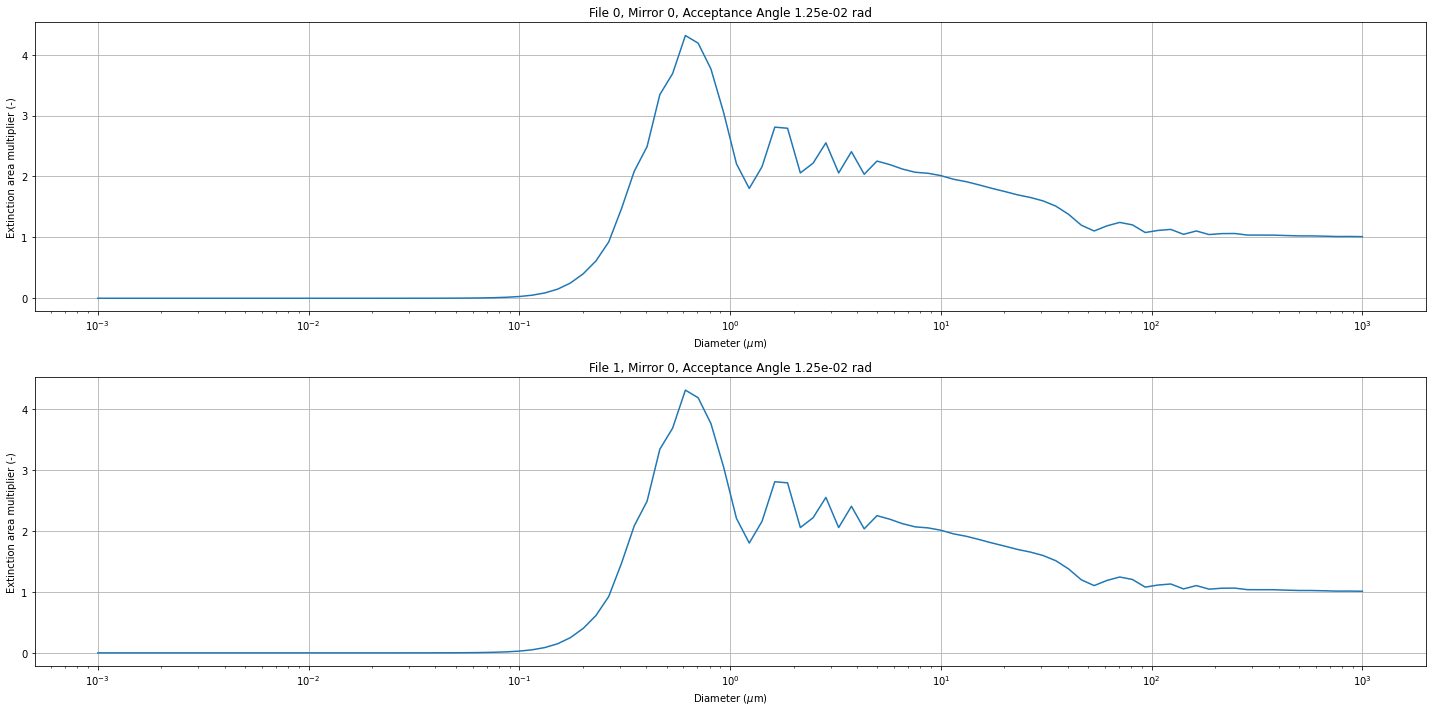

In [8]:
imodel.helios.plot_extinction_weights(sim_data_train,fig_kwargs={'figsize':(20,10)})
ext_weights = imodel.helios.extinction_weighting[0].copy()

# Fit non-stochastic model

In [9]:
hrz0_multi,sse_multi = imodel.fit_least_squares(sim_data_train,reflect_data_train)
imodel.update_model_parameters(hrz0_multi)
imodel.save(ls_save_file,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

Fitting hrz0 with least squares ...
... done! 
 hrz0 = 1.8634899436473418


TypeError: save() got an unexpected keyword argument 'training_simulation_data'

Set extinction coefficients. Instead of computing, we set them directly using set_extinction_coefficients since we know that they are all the same (because the dust and acceptance angles of the measurement are all the same).

In [ ]:
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(sim_data_total,imodel.loss_model,verbose=True) 

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)


In [ ]:
imodel.predict_reflectance(sim_data_total)
fig,ax,_,_,_  = imodel.plot_soiling_factor( sim_data_total,
                                            reflectance_data=reflect_data_total,
                                            figsize=(20,20),
                                            reflectance_std='measurements',
                                            fig_title=training_string,
                                            return_handles=True,
                                            repeat_y_labels=False)
# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')
fig.tight_layout()

# Parameter Estimation for the Stochastic Model

## Semi-physical model 

### Compute deposition velocity, angles, and Mie Extinction Weights

In [ ]:
imodel.helios_angles(   sim_data_train,
                        reflect_data_train,
                        second_surface=second_surf)
                        
# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_train,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment_train))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

### Fitting
Maximum Likelihood Estmation (MLE) or Maximum *A Posteriori* (MAP)

In [ ]:

log_param_hat,log_param_cov = imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=False )

s = np.sqrt(np.diag(log_param_cov))
param_ci = log_param_hat + 1.96*s*np.array([[-1],[1]])
lower_ci = imodel.transform_scale(param_ci[0,:])
upper_ci = imodel.transform_scale(param_ci[1,:])
param_hat = imodel.transform_scale(log_param_hat)
hrz0_mle,sigma_dep_mle = param_hat
print(f'hrz0: {hrz0_mle:.2e} [{lower_ci[0]:.2e},{upper_ci[0]:.2e}]')
print(f'\sigma_dep: {sigma_dep_mle:.2e} [{lower_ci[1]:.2e},{upper_ci[1]:.2e}]')

# # MAP Fitting
# sigma_h = np.log(np.log(10.0))
# mu_h = np.log(np.log(2.0))
# sigma_sigma_dep = 5.0
# mu_sigma_dep = -2.0
# priors =    {   'log_log_hrz0': norm(scale=sigma_h,loc=mu_h),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#             }
# param_hat,param_cov = imodel.fit_map(   sim_data_train,
#                                         reflect_data_train,
#                                         priors,verbose=True,
#                                         transform_to_original_scale=True)


hrz0_mle,sigma_dep_mle = param_hat
imodel.update_model_parameters(param_hat)
imodel.save(sp_save_file,
            log_p_hat=log_param_hat,
            log_p_hat_cov=log_param_cov,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
_,_,_ = imodel.plot_soiling_factor( sim_data_train,
                            reflectance_data=reflect_data_train,
                            figsize=(10,10),
                            reflectance_std='mean',
                            save_path="results/",
                            fig_title="On Training Data"    )

### Predict with test data and plot

In [ ]:
imodel.helios_angles(   sim_data_total,
                        reflect_data_total,
                        second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_total,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

In [ ]:
imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor
fig_total,ax_total,_,_,_   = imodel.plot_soiling_factor( sim_data_total,
                            reflectance_data=reflect_data_total,
                            figsize=(12,15),
                            reflectance_std='mean',
                            save_path="results/semi_physical_fitting.png",
                            fig_title=training_string+" (Semi-Physical)",
                            return_handles=True,
                            repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)


## Constant Mean Desposition Velocity
### Compute deposition velocity, angles, and Mie Extinction Weights

In [ ]:
constant_imodel = smf.constant_mean_deposition_velocity(parameter_file)
constant_imodel.helios_angles(  sim_data_train,
                                reflect_data_train,
                                second_surface=second_surf)

# extinction weights not needed for constant mean model

### Fitting
MLE or MAP

In [ ]:
log_param_hat_con,log_param_cov_con = constant_imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=False)
imodel.save(cm_save_file,
            log_p_hat=log_param_hat_con,
            log_p_hat_cov=log_param_cov_con,
            training_simulation_data=sim_data_train,
            training_reflectance_data=reflect_data_train)

s_con = np.sqrt(np.diag(log_param_cov_con))
param_ci_con = log_param_hat_con + 1.96*s_con*np.array([[-1],[1]])
lower_ci_con = constant_imodel.transform_scale(param_ci_con[0,:])
upper_ci_con = constant_imodel.transform_scale(param_ci_con[1,:])
param_hat_con = constant_imodel.transform_scale(log_param_hat_con)
mu_tilde,sigma_dep_con = param_hat_con
print(f'mu_tilde: {mu_tilde:.2e} [{lower_ci_con[0]:.2e},{upper_ci_con[0]:.2e}]')
print(f'\sigma_dep (constant mean model): {sigma_dep_con:.2e} [{lower_ci_con[1]:.2e},{upper_ci_con[1]:.2e}]')

# # MAP Fitting
# sigma_m = 1.5
# mu_m = -10.0
# sigma_sigma_dep = 5.0
# mu_sigma_dep = -2.0
# priors =    {   'log_mu_tilde': norm(scale=sigma_m,loc=mu_m),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#               }

# param_hat,param_cov = constant_imodel.fit_map(  sim_data_train,
#                                                 reflect_data_train,
#                                                 priors,verbose=True,
#                                                 transform_to_original_scale=True)


constant_imodel.update_model_parameters(param_hat_con)
constant_imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
_,_,_ = constant_imodel.plot_soiling_factor(    sim_data_train,
                                        reflectance_data=reflect_data_train,
                                        figsize=(10,10),
                                        reflectance_std='mean',
                                        save_path="results/",
                                        fig_title="On Training Data"    )

### Predict with test data and plot

In [ ]:
constant_imodel.helios_angles(  sim_data_total,
                                reflect_data_total,
                                second_surface=second_surf)

# Extinction weights not needed for constant mean model
                        
constant_imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor

In [ ]:
fig_total,ax_total,_,_,_   = constant_imodel.plot_soiling_factor(   sim_data_total,
                                                                    reflectance_data=reflect_data_total,
                                                                    figsize=(12,15),
                                                                    reflectance_std='mean',
                                                                    save_path="results/constant_mean_fitting.png",
                                                                    fig_title=training_string+" (Constant Mean)",
                                                                    return_handles=True,
                                                                    repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)
